In [41]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
import os

In [42]:
class catDataset(Dataset):
    def __init__(self, img_dir, second_img_dir):
        self.img_dir = img_dir
        self.img_names = []

        for filename in os.listdir(img_dir):
            file_path = os.path.join(img_dir, filename)
            if os.path.isfile(file_path):
                self.img_names.append(file_path)
        
        for filename in os.listdir(second_img_dir):
            file_path = os.path.join(second_img_dir, filename)
            if os.path.isfile(file_path):
                self.img_names.append(file_path)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        print(self.img_names[idx])
        image = read_image(self.img_names[idx])
        return image, 0


In [43]:
def show_img(img_tensor):
    image_to_display = img_tensor.permute(1, 2, 0).numpy()
    plt.imshow(image_to_display)
    plt.show()


In [44]:
class DDPM_Scheduler(nn.Module):
    def __init__(self, num_time_steps: int=1000):
        super().__init__()
        self.beta = torch.linspace(1e-4, 0.02, num_time_steps, requires_grad=False)
        alpha = 1 - self.beta
        self.alpha = torch.cumprod(alpha, dim=0).requires_grad_(False)

    def forward(self, t):
        return self.beta[t], self.alpha[t]

In [45]:
class ResBlock(nn.Module):
    def __init__(self, C: int, num_groups: int, dropout_prob: float):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.gnorm1 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
        self.gnorm2 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
        self.conv1 = nn.Conv2d(C, C, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(C, C, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p=dropout_prob, inplace=True)

    def forward(self, x, embeddings):
        x = x + embeddings[:, :x.shape[1], :, :]
        r = self.conv1(self.relu(self.gnorm1(x)))
        r = self.dropout(r)
        r = self.conv2(self.relu(self.gnorm2(r)))
        return r + x

./mycat_64x64/mycat_1.png


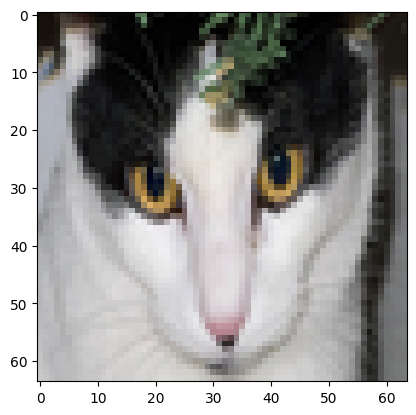

(tensor(0.0002), tensor(0.9991))

In [46]:
ds=catDataset("./cats","./mycat_64x64")

show_img(ds[-1][0])
sch = DDPM_Scheduler()
sch.forward(5)